# Data Understanding

The data understanding phase involved several key activities to gain familiarity with the dataset and uncover valuable insights:

- Initial data collection: The initial step was to collect the dataset from Kaggle, specifically the Amazon US Customer Reviews Dataset. The [dataset](https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset) was loaded in Kaggle. Since our project focuses only on electronics and digital equipment staff, we collect the following purchase categories: "Electronics", "Camera", "Mobile_Electronics", "PC", "Software", "Wireless".

- Data description: Examination of the “gross” or “surface” properties of the acquired data. This step includes identification of the format of the data, the quantity of data, for example number of records and fields in each table, the identities of the fields and any other surface features of the data which have been discovered.

- Data exploration: This task tackles the data mining questions, which can be addressed
using querying, visualization and reporting. These include: distribution
of key attributes, for example the target attribute of a prediction task;
relations between pairs or small numbers of attributes; results of
simple aggregations; properties of significant sub-populations; simple
statistical analyses. 

- Data quality verification: Examinination of the quality of the data, addressing questions such as: is the
data complete (does it cover all the cases required)? Is it correct or
does it contain errors and if there are errors how common are they?
Are there missing values in the data? If so how are they represented,
where do they occur and how common are they?

In [1]:
# all neccessary imports
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from nltk.corpus import stopwords
import torch
from tqdm.auto import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load tokenizer and model weights
tokenizer = RobertaTokenizer.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')
model = RobertaForSequenceClassification.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
batch = tokenizer.encode('you are an idiot', return_tensors='pt')
neutral_prob = model(batch).logits[0].softmax(-1)[0]
neutral_prob

tensor(0.0003, grad_fn=<SelectBackward0>)

## Collect initial data

In [4]:
# collect data
categories = ["Electronics", "Camera", "Mobile_Electronics", "PC", "Software", "Wireless"]

category_datasets = []
for category in tqdm(categories):
    kaggle_dataset_path = f"/kaggle/input/amazon-us-customer-reviews-dataset/amazon_reviews_us_{category}_v1_00.tsv"

    category_dataset = pd.read_csv(kaggle_dataset_path, sep='\t', quoting=3)
    category_datasets.append(category_dataset)
    print(f"Loaded dataset for {category}")
    
dataset = pd.concat(category_datasets)

  0%|          | 0/6 [00:00<?, ?it/s]

Loaded dataset for Electronics
Loaded dataset for Camera
Loaded dataset for Mobile_Electronics
Loaded dataset for PC
Loaded dataset for Software
Loaded dataset for Wireless


In [5]:
# check that dataset's collection is correct
dataset.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31


## Describe data

In [6]:
# number of records and fields
dataset.shape  

(21253324, 15)

In [7]:
# head
dataset.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [8]:
# tail
dataset.tail()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
9002016,US,51706541,R3ZKCWKG4097P,B00000J40U,91541241,Garmin GPS III Waterproof Hiking GPS,Wireless,4,12,12,N,N,When you really need to know.,We train search and rescue dogs in Colorado an...,1999-07-13
9002017,US,51660758,R2D0X18EHNKEOJ,B00000JBRT,226432064,Uniden BC245XLT Handheld Scanner,Wireless,5,10,13,N,N,A must have for trunked radio systems,I have had the BC245XLT for almost a week now....,1999-07-13
9002018,US,53076522,R292SJRN80H8OQ,B00000DM9D,730627849,Garmin GPS II Plus Waterproof Hiking GPS,Wireless,4,1,6,N,N,Better suit for US market,I brought my Gramin GPS II last month. The fe...,1999-01-03
9002019,US,52780824,R3HA5IXDCVJ65K,B00000DM9D,730627849,Garmin GPS II Plus Waterproof Hiking GPS,Wireless,5,24,25,N,N,"A rugged, spectacular essential for wilderness...","I made a 4 day, 3 night solo hike in Big Bend ...",1998-12-26
9002020,US,52165522,R3T0HNHSZUC0ZW,B00000DM9D,730627849,Garmin GPS II Plus Waterproof Hiking GPS,Wireless,4,15,15,N,N,Excellent Product; Easier to use than other mo...,"The Garmin GPS II, II Plus, and III are all ex...",1998-12-04


In [9]:
# data types
dataset.dtypes

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
product_category     object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtype: object

In [10]:
# common info about the data 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21253324 entries, 0 to 9002020
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   marketplace        object
 1   customer_id        int64 
 2   review_id          object
 3   product_id         object
 4   product_parent     int64 
 5   product_title      object
 6   product_category   object
 7   star_rating        int64 
 8   helpful_votes      int64 
 9   total_votes        int64 
 10  vine               object
 11  verified_purchase  object
 12  review_headline    object
 13  review_body        object
 14  review_date        object
dtypes: int64(5), object(10)
memory usage: 2.5+ GB


## Explore data

### 1. Review neutrality 

It is still needed for summarization task

In [11]:
neutral_distr = []
toxic = dict()
model.to('cuda:0')

for text in tqdm(dataset['review_body'].tolist()[:2000]):
    batch = tokenizer.encode(text, return_tensors='pt', max_length=512).to('cuda:0')
    with torch.no_grad():
        neutral_prob = model(batch).logits[0].softmax(-1)[0].item()
    neutral_distr.append(neutral_prob)
    if neutral_prob < 0.3:
        toxic[text] = neutral_prob

  0%|          | 0/2000 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [12]:
sum([d < 0.5 for d in neutral_distr])

21

In [13]:
len(toxic)

20

In [14]:
list(toxic.items())[:10]

[('Trash, returned mine after 2 days. The pads are hard and very uncomfortable. It is completely plastic  and feels like it is  about to break. DONT BUY',
  0.17076949775218964),
 ("The picture quality is garbage. And the second screen barely works and the speaker's don't work. I would like to find the person that sent me this garbage. Or Broke Garbage.",
  0.007328052073717117),
 ("The radio would not pick a station close plus it would play 95 fm when it was on 89.3 fm not worth the money it's junk",
  0.033601440489292145),
 ('This piece of sh!t does not work for the note 5 wastebof money',
  0.009439347311854362),
 ('made like crap, but cost 3 bucks shipped prime so it was worth it.  The button barely works half the time but the mic is ok.  Will buy again as a throw away option',
  0.01823626458644867),
 ('Piece of crap cables. Distorted sound after a month. Snow on the screen. Used to be great quality, not anymore. Every single one does the same thing.',
  0.007486754562705755),
 (

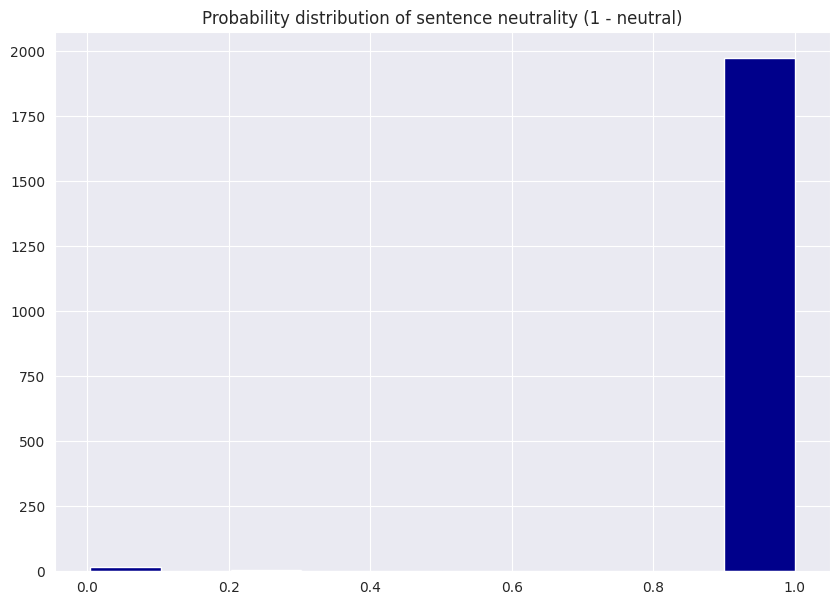

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.hist(neutral_distr, color='darkblue')
plt.title('Probability distribution of sentence neutrality (1 - neutral)')
plt.show()

### 2. Correlation analysis

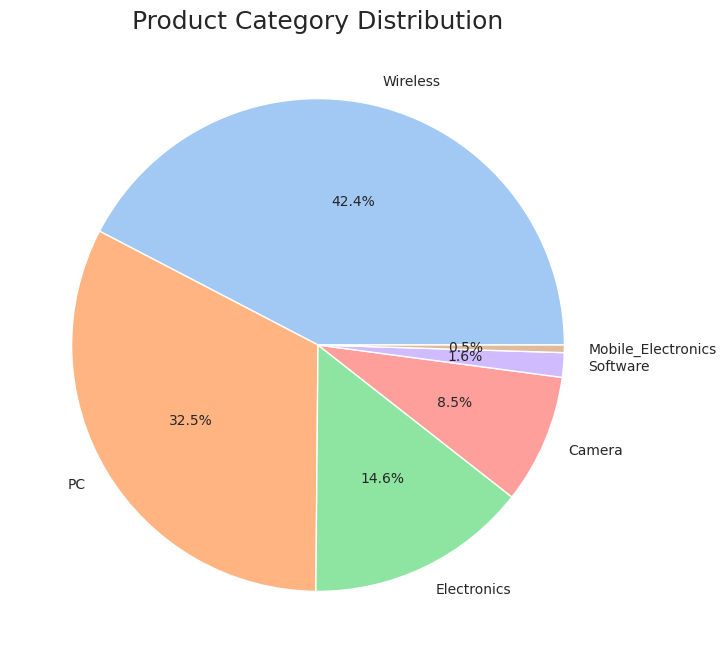

In [16]:
category_counts = dataset['product_category'].value_counts()

colors = sns.color_palette('pastel')[0:len(category_counts)]

plt.figure(figsize=(8, 8)) 
plt.pie(category_counts, labels=category_counts.index, colors=colors, autopct='%1.1f%%')
plt.title('Product Category Distribution', fontsize=18)
plt.show()

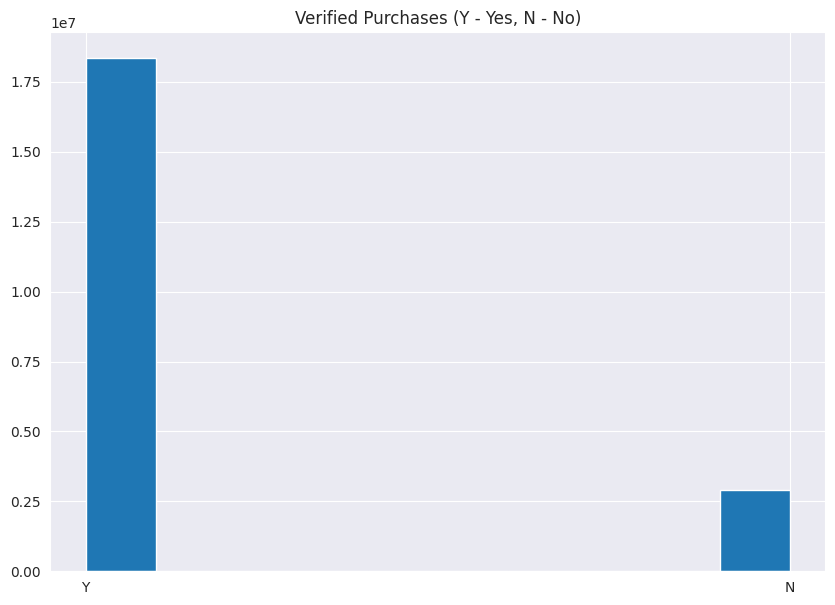

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))

plt.hist(dataset.verified_purchase)
plt.title("Verified Purchases (Y - Yes, N - No)")
plt.show()

In [18]:
vine_program = dataset.vine.apply(lambda x: x == 'Y').mean()
print(f"{vine_program * 100:.3f}% of all user reviews were done in VINE program of Amazon")

0.426% of all user reviews were done in VINE program of Amazon


Check the hypothesis of useful VINE reviews:


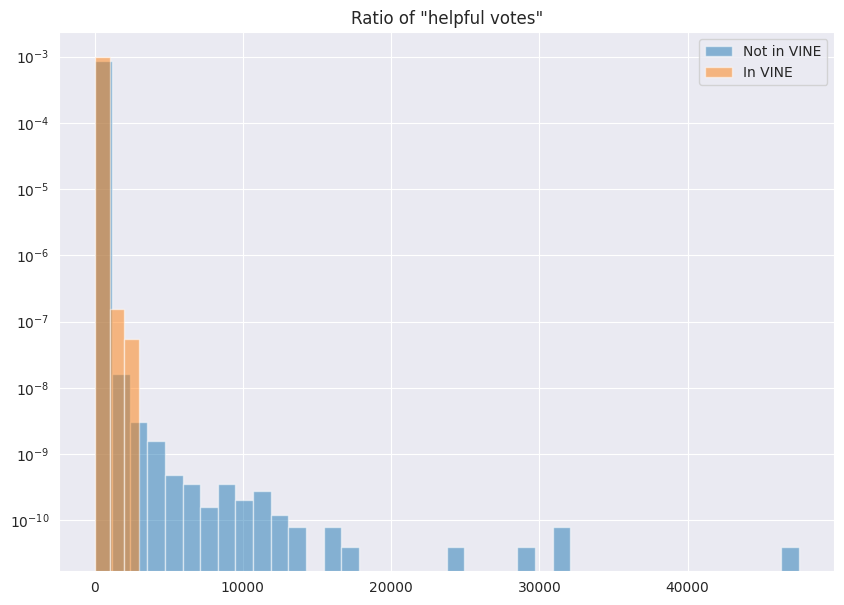

In [19]:
print("Check the hypothesis of useful VINE reviews:")

fig, ax = plt.subplots(figsize=(10, 7))

plt.title('Ratio of "helpful votes"')
plt.hist(dataset[dataset.vine != 'Y'].helpful_votes, bins=40, density=True, alpha=0.5, label='Not in VINE', log=True)
plt.hist(dataset[dataset.vine == 'Y'].helpful_votes, bins=3, density=True, alpha=0.5, label='In VINE', log=True)
plt.legend()
plt.show()

In [20]:
print("The reviews in the dataset are from", dataset.review_date.min(), "till", dataset.review_date.max())

The reviews in the dataset are from 1998-09-21 till 2015-08-31


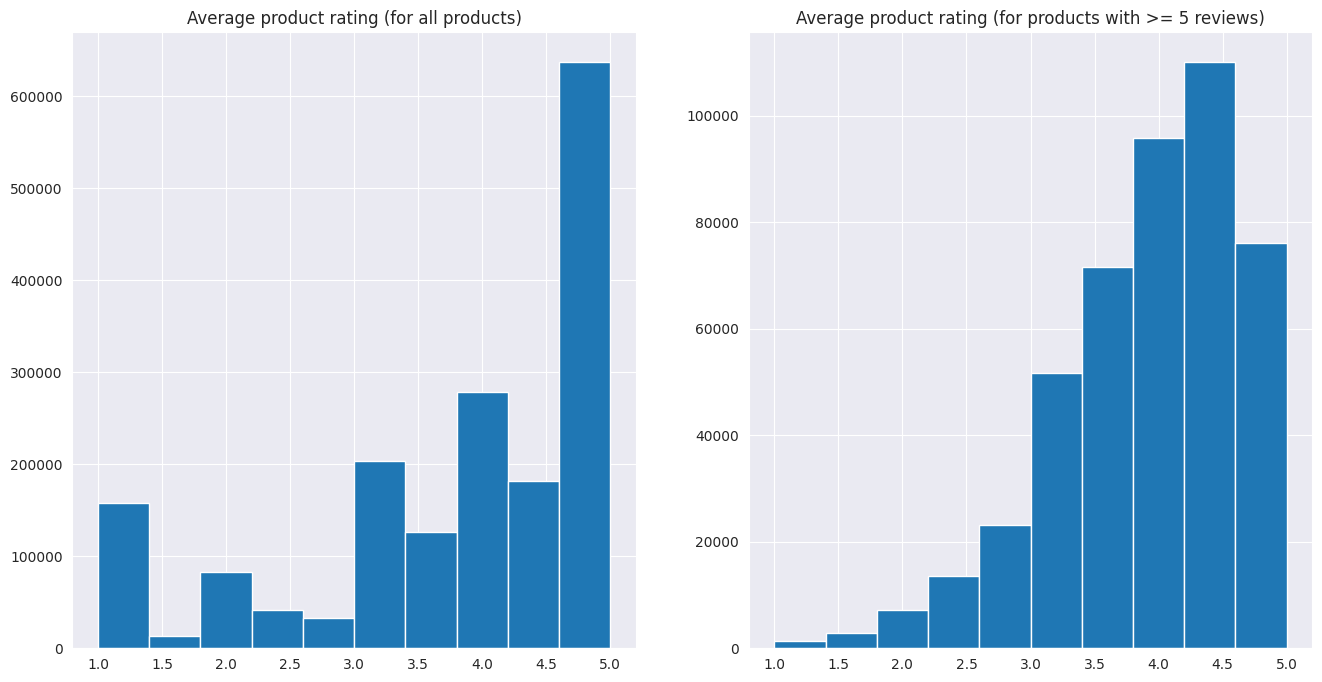

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('Average product rating (for all products)')
plt.hist(dataset.groupby('product_id')['star_rating'].apply(np.mean))
plt.subplot(122)
plt.title('Average product rating (for products with >= 5 reviews)')
plt.hist(dataset.groupby('product_id')['star_rating'].apply(lambda x: None if len(x) < 5 else np.mean(x)))
plt.show()

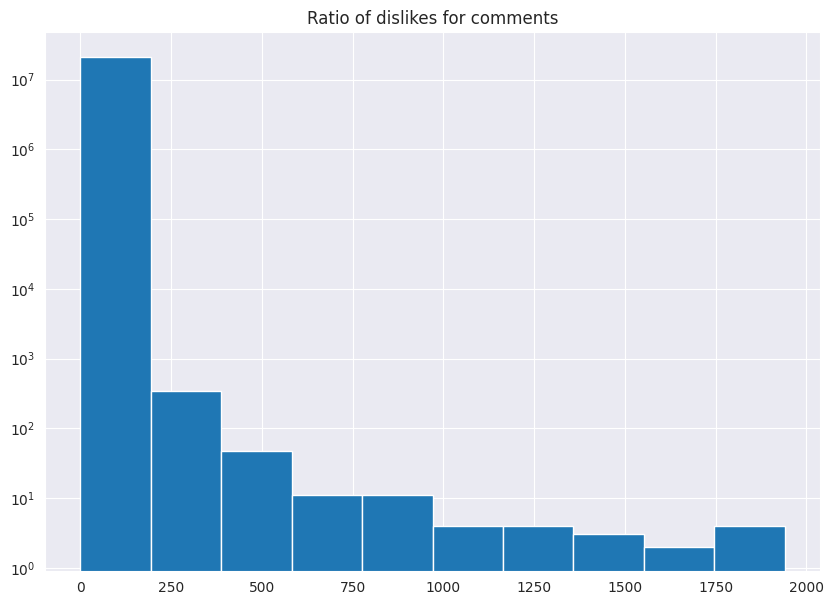

In [22]:
fig, ax = plt.subplots(figsize=(10, 7))
dataset['useless_votes'] = dataset.total_votes - dataset.helpful_votes
plt.hist(dataset['useless_votes'], log=True)
plt.title("Ratio of dislikes for comments")
plt.show()

Some insights from dataset:
- **For data modeling stage: like/dislike ratio could be another proxy for usefulness when aggregating summaries across reviews**

### 3. Explore some groupings

In [23]:
dataset.groupby(['product_id'])['customer_id'].count().sort_values()

product_id
B01KJDBTMK        1
B01LX353Y8        1
B01LZ1IBT7        1
B01M3N0YDM        1
B01M5JEUYE        1
              ...  
B003L1ZYYM    15348
B006GWO5WK    15680
B00BWYQ9YE    16806
B00JG8GOWU    18315
B0051VVOB2    23313
Name: customer_id, Length: 1756130, dtype: int64

In [24]:
dataset.groupby(['customer_id'])['product_id'].count().sort_values()

customer_id
10067          1
10071          1
10077          1
10083          1
10090          1
            ... 
30208851     872
32038204     905
53037408     937
49266466    1002
44834233    1017
Name: product_id, Length: 9584821, dtype: int64

### 4. Wordcloud

In [25]:
merged_text = ' '.join(dataset['review_body'].tolist()[:10000])

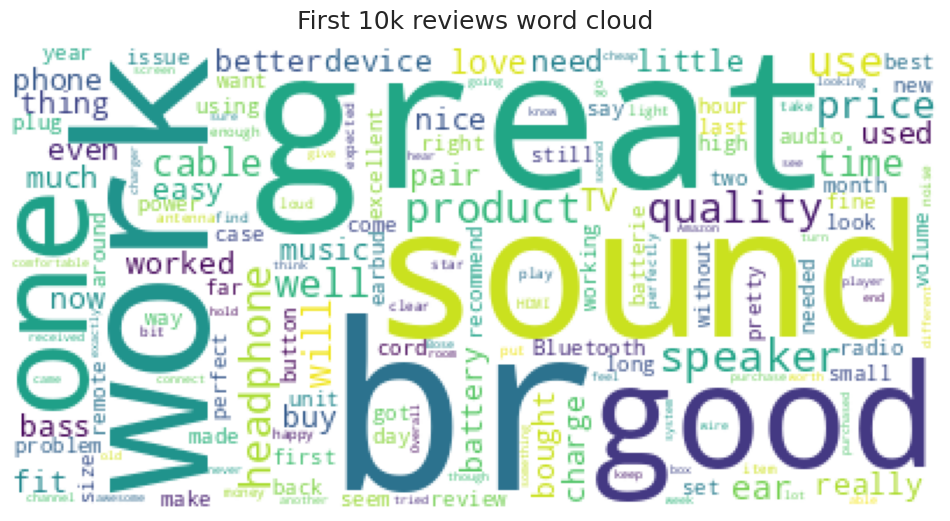

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))

wc = WordCloud(background_color='white', 
               max_font_size=100,
                collocations=False) \
    .generate(merged_text)

plt.grid(False)
plt.axis('off')
plt.imshow(wc)
plt.title("First 10k reviews word cloud", fontsize=18, y=1.02)
plt.show()

Some insights from dataset:

- **"br" is probably just HTML tag, so it is recommended to clean the texts before modeling**

## Verify data quality

In [27]:
# check missing data
dataset.isna().sum()

marketplace             0
customer_id             0
review_id               0
product_id              0
product_parent          0
product_title          16
product_category        0
star_rating             0
helpful_votes           0
total_votes             0
vine                    0
verified_purchase       0
review_headline       313
review_body          1301
review_date             0
useless_votes           0
dtype: int64

In [28]:
# check number of unique values
dataset.nunique()

marketplace                 1
customer_id           9584821
review_id            21253324
product_id            1756130
product_parent        1509744
product_title         1515217
product_category            6
star_rating                 5
helpful_votes            1606
total_votes              1680
vine                        2
verified_purchase           2
review_headline       9525807
review_body          19370824
review_date              5926
useless_votes             417
dtype: int64

In [29]:
# check number of duplicate rows
dataset.duplicated().sum()

0